# **PhoBERT_Logistic Regression**

# Module 1: Tiền xử lý tổng quát

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# 1. Cài đặt thư viện cần thiết
!pip install underthesea rouge-score scikit-learn transformers torch pandas numpy

import pandas as pd
import numpy as np
import re
import torch
from underthesea import word_tokenize, sent_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
from transformers import AutoModel, AutoTokenizer
from google.colab import drive

# 2. Kết nối Google Drive
drive.mount('/content/drive')

# 3. Hàm làm sạch văn bản (Logic từ file mẫu)
def clean_text(text):
    if not isinstance(text, str): return ""
    text = re.sub(r'<[^>]+>', '', text)  # Xóa HTML
    text = re.sub(r'http\S+', '', text)  # Xóa URL
    text = re.sub(r'\s+', ' ', text).strip() # Chuẩn hóa khoảng trắng
    return text

# 4. Hàm tách từ (Logic từ file mẫu)
def segment_text(text):
    try:
        return word_tokenize(text, format="text")
    except:
        return text

# 5. Hàm chuẩn bị dữ liệu đầu vào cho PhoBERT (Fairness Layer)
# Tách văn bản thành các câu, làm sạch và giới hạn số câu để tránh quá tải
def preprocess_for_phobert(raw_content, max_sentences=20):
    clean_content = clean_text(raw_content)
    # Tách thành các câu đơn
    sentences = sent_tokenize(clean_content)
    # Tách từ cho từng câu (Segment) để tối ưu cho PhoBERT
    segmented_sentences = [segment_text(s) for s in sentences]
    return segmented_sentences[:max_sentences]

# 6. Tải dữ liệu
df = pd.read_csv("/content/drive/MyDrive/NLP_PROJECT/data/csv_file/original_summary.csv")

# Chia tập train/test theo tỷ lệ văn bản (Document-level split)
train_df = df.iloc[:80].reset_index(drop=True)
test_df  = df.iloc[80:].reset_index(drop=True)

df.head(2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,title,content,summary
0,Làng gốm Thanh Hà giành giải 'Điểm du lịch cộn...,"Sáng 27/9, làng gốm Thanh Hà (phường Thanh Hà,...","Làng gốm Thanh Hà được vinh danh là ""Điểm du l..."
1,"""Đọc bã"" cà phê đoán vận mệnh ở Thổ Nhĩ Kỳ","Ở Thổ Nhĩ Kỳ, cà phê đi kèm một chút định mệnh...","Ở Thổ Nhĩ Kỳ, khi uống cạn cà phê, người dân t..."


# Module 2: Mô hình chính

In [26]:
# Cài đặt thư viện transformers để dùng pre-trained model
!pip install transformers torch

import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
from rouge_score import rouge_scorer
import os
from rouge_score import rouge_scorer
from underthesea import word_tokenize

In [27]:
# 1. Cấu hình thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Tải PhoBERT Pre-trained (VinAI)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
phobert = AutoModel.from_pretrained("vinai/phobert-base").to(device)

In [28]:
# 3. Hàm chuyển câu thành vector (Embedding) dùng Mean Pooling
def get_phobert_embeddings(sentences, batch_size=16):
    """
    Chuyển câu thành vector dùng Mean Pooling
    """
    if len(sentences) == 0: return np.zeros((0, 768))

    all_embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch_texts = sentences[i : i + batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = phobert(**inputs)
            # MEAN POOLING STRATEGY
            mask = inputs['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
            masked_embeddings = outputs.last_hidden_state * mask
            sum_embeddings = torch.sum(masked_embeddings, 1)
            sum_mask = torch.clamp(mask.sum(1), min=1e-9)
            mean_pooled = sum_embeddings / sum_mask
            embeddings = mean_pooled.cpu().numpy()

        all_embeddings.append(embeddings)

    if not all_embeddings: return np.zeros((0, 768))
    return np.vstack(all_embeddings)

# 4. Hàm tạo đặc trưng thủ công (Vị trí & Độ dài)
def get_explicit_features(sentences):
    """
    Tạo đặc trưng thủ công: Vị trí & Độ dài (BASE MODEL)
    """
    num_sents = len(sentences)
    features_list = []

    for i, sent in enumerate(sentences):
        # 1. Vị trí tuyến tính (Quan trọng cho Lead Bias)
        linear_pos = i / max(num_sents, 1)

        # 2. Độ dài câu (Câu dài thường nhiều thông tin hơn)
        length_feat = np.log1p(len(sent.split()))

        features_list.append([linear_pos, length_feat])

    return np.array(features_list)

In [29]:
# Chuẩn bị dữ liệu huấn luyện
# Khởi tạo công cụ chấm điểm ROUGE để gán nhãn
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=False)

# Hàm tạo dữ liệu huấn luyện (Vector + Nhãn giả)
def prepare_training_data(df):
    X_vectors = []
    y_labels = []

    for _, row in df.iterrows():
        # Sử dụng hàm tiền xử lý mới (đã cập nhật ở Module 1)
        sentences = preprocess_for_phobert(row['content'])
        if len(sentences) == 0: continue

        # Tạo nhãn giả (0/1) dựa trên độ tương đồng ROUGE với tóm tắt gốc
        ref_summary = clean_text(str(row['summary'])) # Làm sạch summary gốc
        ref_segmented = segment_text(ref_summary)     # Tách từ summary gốc

        scores = []
        for sent in sentences:
            s = scorer.score(ref_segmented, sent)
            avg = (s['rouge1'].fmeasure + s['rougeL'].fmeasure) / 2
            scores.append(avg)

        # Gán nhãn 1 cho Top-3 câu có điểm cao nhất
        k = min(3, len(sentences))
        top_indices = np.argsort(scores)[-k:]
        labels = [0] * len(sentences)
        for idx in top_indices:
            labels[idx] = 1

        # Tạo vector đặc trưng tổng hợp
        vectors = get_phobert_embeddings(sentences)     # Vector ngữ nghĩa (768 chiều)
        explicit = get_explicit_features(sentences)     # Vector thủ công (2 chiều)
        final_features = np.hstack([vectors, explicit]) # Ghép lại (770 chiều)

        X_vectors.append(final_features)
        y_labels.extend(labels)

    if len(X_vectors) > 0:
        X_final = np.vstack(X_vectors)
        y_final = np.array(y_labels)
    else:
        X_final, y_final = np.array([]), np.array([])

    return X_final, y_final

# Thực hiện tạo dữ liệu
X_train_emb, y_train = prepare_training_data(train_df)

In [30]:
# Huấn luyện mô hình & Dự đoán
# 1. Class Logistic Regression tự xây dựng
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.05, n_iterations=2000, class_weight=None):
        self.lr = learning_rate
        self.n_iter = n_iterations
        self.weights = None
        self.bias = None
        self.class_weight = class_weight

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Xử lý mất cân bằng dữ liệu (Class Weight)
        sample_weights = np.ones(n_samples)
        if self.class_weight == 'balanced':
            n_0 = len(y[y == 0])
            n_1 = len(y[y == 1])
            if n_1 > 0:
                w1 = n_samples / (2 * n_1)
                w0 = n_samples / (2 * n_0)
                sample_weights = np.where(y == 1, w1, w0)

        # Gradient Descent
        for _ in range(self.n_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            error = (y_predicted - y) * sample_weights
            dw = (1 / n_samples) * np.dot(X.T, error)
            db = (1 / n_samples) * np.sum(error)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        return np.column_stack((1 - y_predicted, y_predicted))

# 2. Huấn luyện mô hình
model = CustomLogisticRegression(learning_rate=0.1, n_iterations=3000, class_weight='balanced')
model.fit(X_train_emb, y_train)

# 3. Hàm trích xuất tóm tắt (Inference)
def extract_summary_phobert(content, model, core_threshold=0.50, neighbor_threshold=0.30, sim_threshold=0.85, min_sentences=3):
    # Tiền xử lý
    sentences = preprocess_for_phobert(content)
    if len(sentences) == 0: return ""

    # Tạo vector đặc trưng
    vectors = get_phobert_embeddings(sentences)
    explicit = get_explicit_features(sentences)
    final_features = np.hstack([vectors, explicit])

    # Dự đoán điểm quan trọng
    probs = model.predict_proba(final_features)[:, 1]

    # Thuật toán chọn câu (Smart Selection)
    candidates = set()
    core_indices = [i for i, p in enumerate(probs) if p >= core_threshold]

    # Fallback nếu không đủ câu nòng cốt
    if len(core_indices) < min_sentences:
        core_indices = np.argsort(probs)[-min_sentences:].tolist()

    # Thêm câu hàng xóm để tăng ngữ cảnh
    for i in core_indices:
        candidates.add(i)
        if i > 0 and probs[i-1] >= neighbor_threshold:
            candidates.add(i-1)
        if i < len(sentences) - 1 and probs[i+1] >= neighbor_threshold:
            candidates.add(i+1)

    # Lọc trùng lặp (MMR-like)
    sorted_candidates = sorted(list(candidates), key=lambda idx: probs[idx], reverse=True)
    final_indices = []

    for idx in sorted_candidates:
        is_duplicate = False
        if len(final_indices) > 0:
            current_vec = vectors[idx].reshape(1, -1)
            selected_vecs = vectors[final_indices]
            sim_scores = cosine_similarity(current_vec, selected_vecs)
            if np.max(sim_scores) > sim_threshold:
                is_duplicate = True

        if not is_duplicate:
            final_indices.append(idx)

    # Sắp xếp lại theo thứ tự xuất hiện gốc
    final_indices = sorted(final_indices)

    # Nối lại thành văn bản (Xóa dấu gạch dưới của tách từ để hiển thị đẹp hơn)
    summary_sents = [sentences[i].replace("_", " ") for i in final_indices]
    return " ".join(summary_sents)

# Module 3: Đánh giá & vẽ biểu đồ

In [47]:
# Đánh giá & Lưu kết quả
# 1. Chạy dự đoán trên tập Test
predicted_summaries = []
for content in test_df["content"]:
    pred = extract_summary_phobert(content, model, min_sentences=4)
    predicted_summaries.append(pred)

# Lưu kết quả vào DataFrame
results_df = test_df.copy()
results_df["predicted_summary"] = predicted_summaries
final_df = results_df[["content", "summary", "predicted_summary"]]

# 2. Hàm tính điểm ROUGE (Chuẩn tiếng Việt)
def evaluate_rouge_vietnamese(preds, refs):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    r1, r2, rl = [], [], []
    for p, r in zip(preds, refs):
        # Đảm bảo input là string và được tách từ
        p_clean = segment_text(clean_text(str(p)))
        r_clean = segment_text(clean_text(str(r)))

        scores = scorer.score(r_clean, p_clean)
        r1.append(scores['rouge1'].fmeasure)
        r2.append(scores['rouge2'].fmeasure)
        rl.append(scores['rougeL'].fmeasure)

    return {k: np.mean(v) * 100 for k, v in zip(["rouge1", "rouge2", "rougeL"], [r1, r2, rl])}

# 3. Tính toán và hiển thị kết quả
rouge_scores = evaluate_rouge_vietnamese(final_df["predicted_summary"], final_df["summary"])

print("KẾT QUẢ ĐÁNH GIÁ (PhoBERT + Custom LR):")
for k, v in rouge_scores.items():
    print(f"{k}: {v:.4f}")

# 4. Lưu file kết quả
output_filename = "phobert_base_results.csv"
final_df.to_csv(output_filename, index=False, encoding='utf-8-sig')

KẾT QUẢ ĐÁNH GIÁ (PhoBERT + Custom LR):
rouge1: 70.1812
rouge2: 39.2764
rougeL: 35.2604


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from difflib import SequenceMatcher
from rouge_score import rouge_scorer

In [ ]:
#  VẼ BIỂU ĐỒ
RESULT_FILE_PATH = "/content/drive/MyDrive/NLP_PROJECT/Model/PhoBERT_results/Result_PhoBERT.csv"
MODEL_NAME = "PhoBERT & LogisticRegression"
col_gen = "predicted_summary"
col_ref = "clean_summary"
col_src = "clean_content"

if not os.path.exists('/content/drive'): drive.mount('/content/drive')

if os.path.exists(RESULT_FILE_PATH):
    df = pd.read_csv(RESULT_FILE_PATH).dropna(subset=[col_gen, col_ref])
else:
    try:
        df = df.copy() 
    except NameError:
        raise FileNotFoundError("Không tìm thấy dữ liệu (File CSV hoặc biến df).")



rouge_results = evaluate_rouge_vietnamese(df[col_gen], df[col_ref])
print(f"ROUGE Results for {MODEL_NAME}: {rouge_results}")

df_current = df.copy()
df_current['gen_len'] = df_current[col_gen].apply(lambda x: len(str(x).split()))
df_current['ref_len'] = df_current[col_ref].apply(lambda x: len(str(x).split()))
df_current['src_len'] = df_current[col_src].apply(lambda x: len(str(x).split()))
df_current['length_group'] = df_current['src_len'].apply(lambda x: "< 300" if x < 300 else ("300-600" if x <= 600 else "> 600"))

ROUGE Results for PhoBERT & LogisticRegression: {'rouge1': np.float64(0.7170617961979371), 'rouge2': np.float64(0.3772999429550593), 'rougeL': np.float64(0.3508459762063971)}


/tmp/ipython-input-2543078352.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=rouge_data, x="Metric", y="Score", palette="viridis")


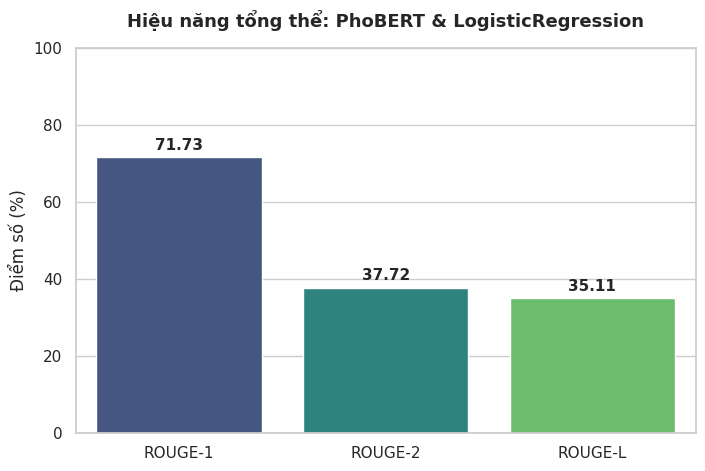

In [ ]:
# Biểu đồ 1 - Hiệu năng Tổng thể
# Tính điểm ROUGE cho toàn bộ tập test
overall_scores = evaluate_rouge(df_current[col_gen], df_current[col_ref])

rouge_data = pd.DataFrame({
    "Metric": ["ROUGE-1", "ROUGE-2", "ROUGE-L"],
    "Score": [overall_scores['rouge1'] * 100, overall_scores['rouge2'] * 100, overall_scores['rougeL'] * 100]
})

plt.figure(figsize=(8, 5))

ax = sns.barplot(data=rouge_data, x="Metric", y="Score", palette="viridis")

for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3, fontweight='bold')

plt.title(f"Hiệu năng tổng thể: {MODEL_NAME}", fontweight='bold', pad=15)
plt.ylim(0, 100)
plt.ylabel("Điểm số (%)")
plt.xlabel("")
plt.show()

/tmp/ipython-input-486330232.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=groups, y=g_scores, palette="magma")


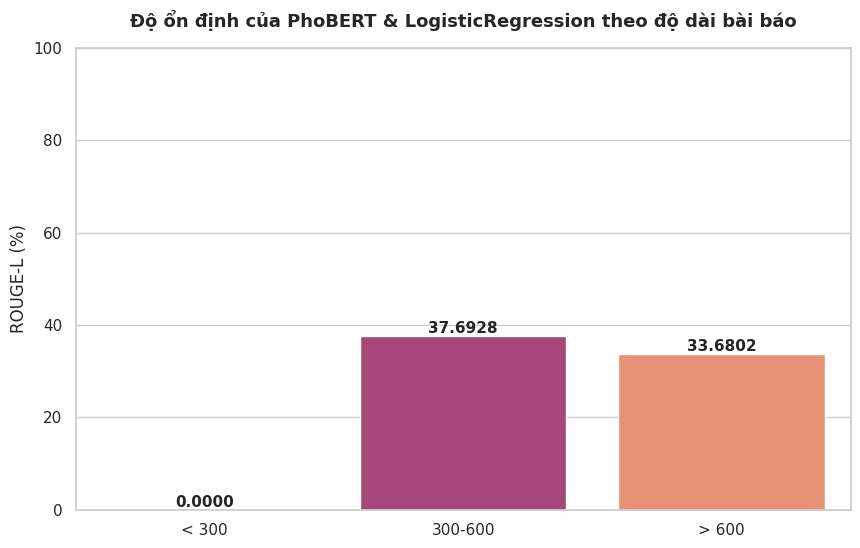

In [51]:
# BIỂU ĐỒ 2: ROUGE THEO ĐỘ DÀI
plt.figure(figsize=(10, 6))
groups = ["< 300", "300-600", "> 600"]
g_scores = []

for g in groups:
    sub = df_current[df_current["length_group"] == g]
    score = evaluate_rouge_vietnamese(sub[col_gen], sub[col_ref])['rougeL'] if len(sub) > 0 else 0
    g_scores.append(score * 100)

sns.barplot(x=groups, y=g_scores, palette="magma")
plt.title(f"Độ ổn định của {MODEL_NAME} theo độ dài bài báo", fontsize=13, weight='bold', pad=15)
plt.ylabel("ROUGE-L (%)", fontsize=12)
plt.xlabel("")
plt.ylim(0, 100)
for i, v in enumerate(g_scores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontweight='bold')
plt.show()


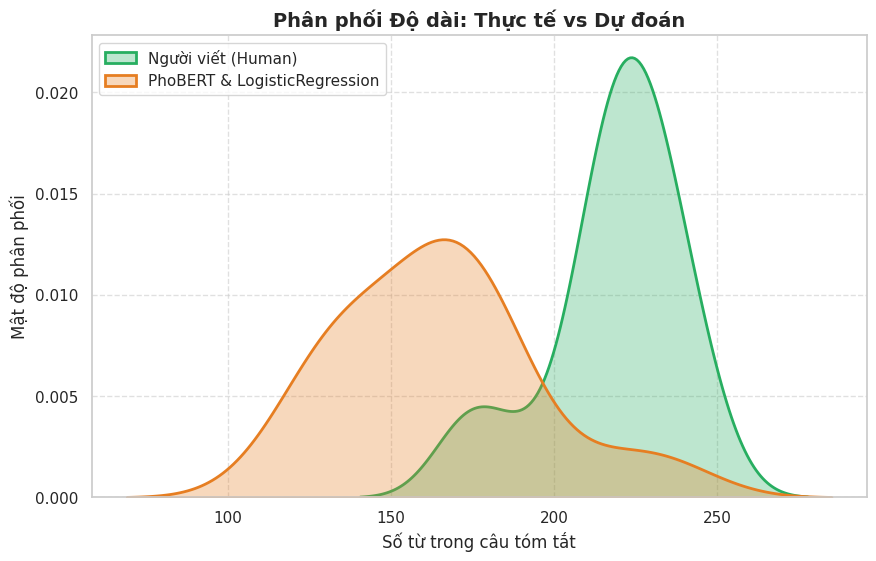

In [52]:
# BIỂU ĐỒ 3: SO SÁNH PHÂN PHỐI ĐỘ DÀI
plt.figure(figsize=(10, 6))

# Người viết - Màu Xanh lá (#27ae60)
sns.kdeplot(
    data=df_current, x="ref_len", fill=True,
    label="Người viết (Human)", color="#27ae60", alpha=0.3, linewidth=2
)

# AI - Màu Cam (#e67e22)
sns.kdeplot(
    data=df_current, x="gen_len", fill=True,
    label=f"{MODEL_NAME}", color="#e67e22", alpha=0.3, linewidth=2
)

plt.title("Phân phối Độ dài: Thực tế vs Dự đoán", fontsize=14, weight='bold')
plt.xlabel("Số từ trong câu tóm tắt", fontsize=12)
plt.ylabel("Mật độ phân phối", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

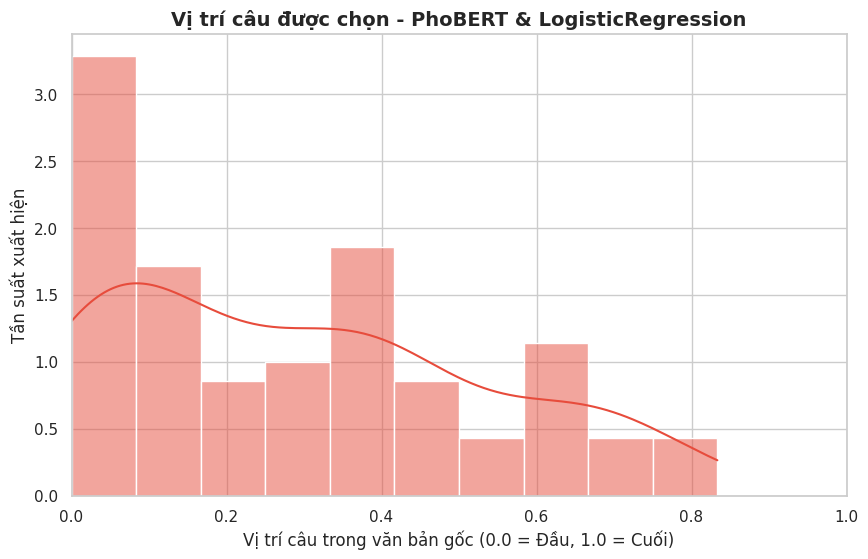

In [53]:
# BIỂU ĐỒ 4: THIÊN KIẾN VỊ TRÍ (LEAD BIAS)
from difflib import SequenceMatcher

def find_best_match_position(generated_text, original_text):
    gen_sents = str(generated_text).split('.')
    org_sents = str(original_text).split('.')
    if len(org_sents) == 0: return []

    positions = []
    for g_sent in gen_sents:
        if len(g_sent) < 10: continue
        best_ratio = 0
        best_idx = 0
        for i, o_sent in enumerate(org_sents):
            ratio = SequenceMatcher(None, g_sent, o_sent).ratio()
            if ratio > best_ratio:
                best_ratio = ratio
                best_idx = i
        if best_ratio > 0.5:
            positions.append(best_idx / len(org_sents))
    return positions

# Thu thập vị trí
all_positions = []
for idx, row in df_current.iterrows():
    pos = find_best_match_position(row[col_gen], row[col_src])
    all_positions.extend(pos)

plt.figure(figsize=(10, 6))
# Dùng màu Cam đậm hoặc Đỏ để cảnh báo về Bias
sns.histplot(all_positions, bins=10, kde=True, color="#e74c3c", stat="density")

plt.title(f"Vị trí câu được chọn - {MODEL_NAME}", fontsize=14, weight='bold')
plt.xlabel("Vị trí câu trong văn bản gốc (0.0 = Đầu, 1.0 = Cuối)", fontsize=12)
plt.ylabel("Tần suất xuất hiện", fontsize=12)
plt.xlim(0, 1)

plt.show()